In [ ]:
!pip install transformers

In [ ]:
import pandas as pd

# 1. Get Data

In [ ]:
# read from csv file 
greek_ids = pd.read_csv('greek_ids.csv')

In [ ]:
# Drop columns with no information
greek_ids = greek_ids.drop(['Unnamed: 0', 'Ύψος'], axis=1)

In [ ]:
# convert it dictionary for easier 
dictQA= greek_ids.to_dict(orient = 'records')
# Check records
# dictQA[0]

# 2. Format Data 

In [ ]:
# Proper Format of Data for Q.A. task
# load all dataset to list object 
data = []

for index in dictQA:
    for k, v in index.items():
      line = ' '.join(index.values()) + " --<input>-- "+ " --<question>-- "+ k+ ": "+ v+ " --<answer>-- "+ "<|endoftext|>"
      data.append(line)
    

In [ ]:
# How the formated data looks
data[:5]

['K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα --<input>--  --<question>-- Αριθμός Δελτίου Ταυτότητας: K8529482 --<answer>-- <|endoftext|>',
 'K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα --<input>--  --<question>-- Ημερομηνία Έκδοσης: 05/04/2010 --<answer>-- <|endoftext|>',
 'K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα --<input>--  --<question>-- Όνομα: Ιωάννα --<answer>-- <|endoftext|>',
 'K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα --<input>--  --<question>-- Given Name: Ioanna --<answer>-- <|endoftext|>',
 'K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δρ

# 3. Split my Data into train and validatons and test


In [ ]:
len(data)

13000

In [ ]:
# Save some data for testing after training 
test = data[11000 : ]
data2 = data[:11000]

In [ ]:
len(test), len(data2)

(2000, 11000)

#4. Tokenization

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config

In [ ]:
# set model name 
model_name = 'gpt2'

In [ ]:
# add extra special tokens
tokenizer = GPT2Tokenizer.from_pretrained(model_name,
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>' )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Check the tokenizer parameters

In [ ]:
tokenizer.special_tokens_map 

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'pad_token': '<|pad|>',
 'unk_token': '<|endoftext|>'}

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|endoftext|> token has the id 50256
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50257


In [ ]:
max_length = max([len(tokenizer.encode(row)) for row in data])

print(f'The longest text is {max_length} tokens long.')

The longest text is 271 tokens long.


# 5. PyTorch Datasets & Dataloaders

The batch size will affect the training time so it is always a good idea to set the batch to the highest number you can fit in the memory of the GPU you are using for training, however this hyper parameter should only affect training time but not model performance. A batch size too large won't fit in memory for some GPUS so you will have to adjust this parameter if you aren't allocated a T4 or K80.

In [ ]:
# Set batch size
batch_size = 2

In [ ]:
!nvidia-smi

Tue Jul  6 10:31:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Libs
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

In [ ]:
class IDDataset(Dataset):

  def __init__(self, df, tokenizer, gpt2_type="gpt2", max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for line in df:
      encodings_dict = tokenizer(line, truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

## Create Dataset 

In [ ]:
from torch.utils.data import random_split

In [ ]:
dataset = IDDataset(data2, tokenizer, max_length=max_length)

In [ ]:
dataset[100]

In [ ]:
train_size = int(0.85 * len(dataset))
val_size = len(dataset)-train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#f'There are {train_size} samples for training, and {val_size} samples for validation testing'
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,350 training samples
1,650 validation samples


## Create Dataloader

Next we will create the dataloader object which will feed the neural network, this combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset), # Sampling for training is Random
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

# Finetune GPT2 Language Model

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

## Set GPU

[GPU or CPU](https://stackoverflow.com/questions/63302534/how-to-write-torch-devicecuda-if-torch-cuda-is-available-else-cpu-as-a-f)

In [ ]:
# cleaning the occupied cuda memory
torch.cuda.empty_cache()

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained(model_name, output_hiden_states=False)

# Create the instance of the model 
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)
# set the token size embedding length
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU 
# if not available then run on cpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.cuda()

#  This step is optional but it wiil enable reproducible runs
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
configuration

## Training parameters

In [ ]:
# We wil create a few variables to define the training parameters of the model
# epochs are the  {training rounds}
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

AdamW is the optimizer of choice for training many models, we will be using Hugging Face's implementation and all of it's defaults, we will also set the number of epochs here, again as we are fine tuning, not retraining, we don't need to run very long models.

In [ ]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import random
import time
import datetime

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

## model train

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# Results - Score

## Loss table

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.76,0.36,0:14:39,0:01:32
2,0.26,0.08,0:14:41,0:01:32


## Loss diagram

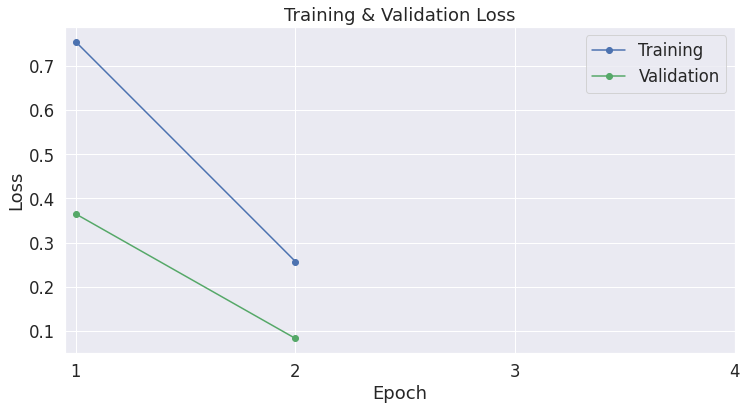

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Let's view the summary of the training process.


## Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

## predict

In [ ]:
# record from data that has not seen
test[12]

'OA0876611 13/01/2018 Τσαμπίκα Tsampika Πέτση Petse Βάιος Ξένη Καλαμάρα 17/12/1997 Καστοριά Δράμα Ζάκυνθος 55076/8 Υ.Α. Δράμα Καστοριά --<input>--  --<question>-- Ημερομηνία Έκδοσης: 13/01/2018 --<answer>-- <|endoftext|>'

In [ ]:
model.eval()

prompt = "<|startoftext|> input: H2561288 27/03/2018 Φιλιππία Philippia Πάνου Panou Δημήτρης Ματίνα Λύτρα 05/10/1968 Χαλκιδική Καβάλα Ζάκυνθος 03957/2 Υ.Α. Καβάλα Χαλκιδική question: Father’s Name "

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 200,
                                top_p=0.95, 
                                num_return_sequences=1
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: <|startoftext|> input: H2561288 27/03/2018 Φιλιππία Philippia Πάνου Panou Δημήτρης Ματίνα Λύτρα 05/10/1968 Χαλκιδική Καβάλα Ζάκυνθος 03957/2 Υ.Α. Καβάλα Χαλκιδική question: Father’s Name  answer: Δημήτρης




# Save model to google drive

In [ ]:
import os
from google.colab import drive

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 499792K
-rw-r--r-- 1 root root      1K Jul  6 10:56 added_tokens.json
-rw-r--r-- 1 root root      1K Jul  6 10:56 config.json
-rw-r--r-- 1 root root    446K Jul  6 10:56 merges.txt
-rw-r--r-- 1 root root 498445K Jul  6 10:56 pytorch_model.bin
-rw-r--r-- 1 root root      1K Jul  6 10:56 special_tokens_map.json
-rw-r--r-- 1 root root      1K Jul  6 10:56 tokenizer_config.json
-rw-r--r-- 1 root root    878K Jul  6 10:56 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Jul  6 10:56 ./model_save/pytorch_model.bin


## set your google Drive path

In [ ]:
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "My Drive","Colab Notebooks","First", "GPT2QA")

drive.mount(gdrive_dir, force_remount=True)

## Copy to Gdrive

In [ ]:
!cp -r ./model_save/ $data_dir

## Everything set up